In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.4.1 cuda: True


In [2]:
## Load dataset
data_path = "../../../rings_varying_radius_c2k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 128
NUM_HIDDEN_LOCAL = 128
NUM_STATS = 128

MCMC_SIZE = 10
BATCH_SIZE = 20
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-4

CUDA = torch.cuda.is_available()
PATH = 'ep-rad-init-eta'
DEVICE = torch.device('cuda:1')

noise_sigma = torch.ones(1) * 0.05
if CUDA:
    noise_sigma = noise_sigma.cuda().to(DEVICE)
Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (noise_sigma, N, K, D, MCMC_SIZE)

In [3]:
from local_enc import *
from global_oneshot import *
from global_mu_rad import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
oneshot_eta = Oneshot_eta(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
enc_eta = Enc_eta_v2(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
if CUDA:
    oneshot_eta.cuda().to(DEVICE)
    enc_z.cuda().to(DEVICE)
    enc_eta.cuda().to(DEVICE)

optimizer =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
models = (oneshot_eta, enc_eta, enc_z)

In [8]:
from ag_ep_rad import *
optimizer2 =  torch.optim.Adam(list(oneshot_eta.parameters())+list(enc_eta.parameters())+list(enc_z.parameters()),lr=1e-4, betas=(0.9, 0.99))

train(models, EUBO_init_eta, optimizer2, Data, Model_Params, Train_Params)

epoch: 0\1000 (20s),  symKL_DB_eta: 4633.091,  symKL_DB_z: 78.639,  gap: 4482.976,  loss: -11159.688,  ess: 5.396
epoch: 1\1000 (20s),  symKL_DB_eta: 4305.957,  symKL_DB_z: 91.346,  gap: 4033.720,  loss: -10902.762,  ess: 5.396
epoch: 2\1000 (21s),  symKL_DB_eta: 3918.481,  symKL_DB_z: 72.266,  gap: 3930.265,  loss: -10650.279,  ess: 5.394
epoch: 3\1000 (20s),  symKL_DB_eta: 3866.566,  symKL_DB_z: 64.729,  gap: 3880.546,  loss: -10554.155,  ess: 5.396
epoch: 4\1000 (19s),  symKL_DB_eta: 3878.338,  symKL_DB_z: 64.801,  gap: 3888.819,  loss: -10514.631,  ess: 5.397
epoch: 5\1000 (19s),  symKL_DB_eta: 3718.244,  symKL_DB_z: 64.030,  gap: 3734.025,  loss: -10601.566,  ess: 5.395
epoch: 6\1000 (19s),  symKL_DB_eta: 3696.174,  symKL_DB_z: 71.614,  gap: 3709.694,  loss: -10083.510,  ess: 5.393
epoch: 7\1000 (19s),  symKL_DB_eta: 3718.829,  symKL_DB_z: 60.728,  gap: 3731.235,  loss: -10730.354,  ess: 5.398
epoch: 8\1000 (20s),  symKL_DB_eta: 3757.600,  symKL_DB_z: 63.564,  gap: 3769.644,  loss

KeyboardInterrupt: 

In [9]:
torch.save(enc_z.state_dict(), "../weights/enc-z-ep-rad-init-eta")
torch.save(enc_eta.state_dict(), "../weights/enc-mu-ep-rad-init-eta")
torch.save(oneshot_eta.state_dict(), "../weights/oneshot-mu-ep-rad-init-eta")

In [12]:
from ag_ep_rad import *

BATCH_SIZE_TEST = 25
Train_Params_Test = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, PATH)
Model_Params_Test = (noise_sigma, N, K, D, 10)
obs, metric_step, reused = test(models, EUBO_init_eta, Data, Model_Params_Test, Train_Params_Test)
(q_mu, _, q_z, _) = reused

CPU times: user 2.29 s, sys: 19.9 ms, total: 2.31 s
Wall time: 2.3 s


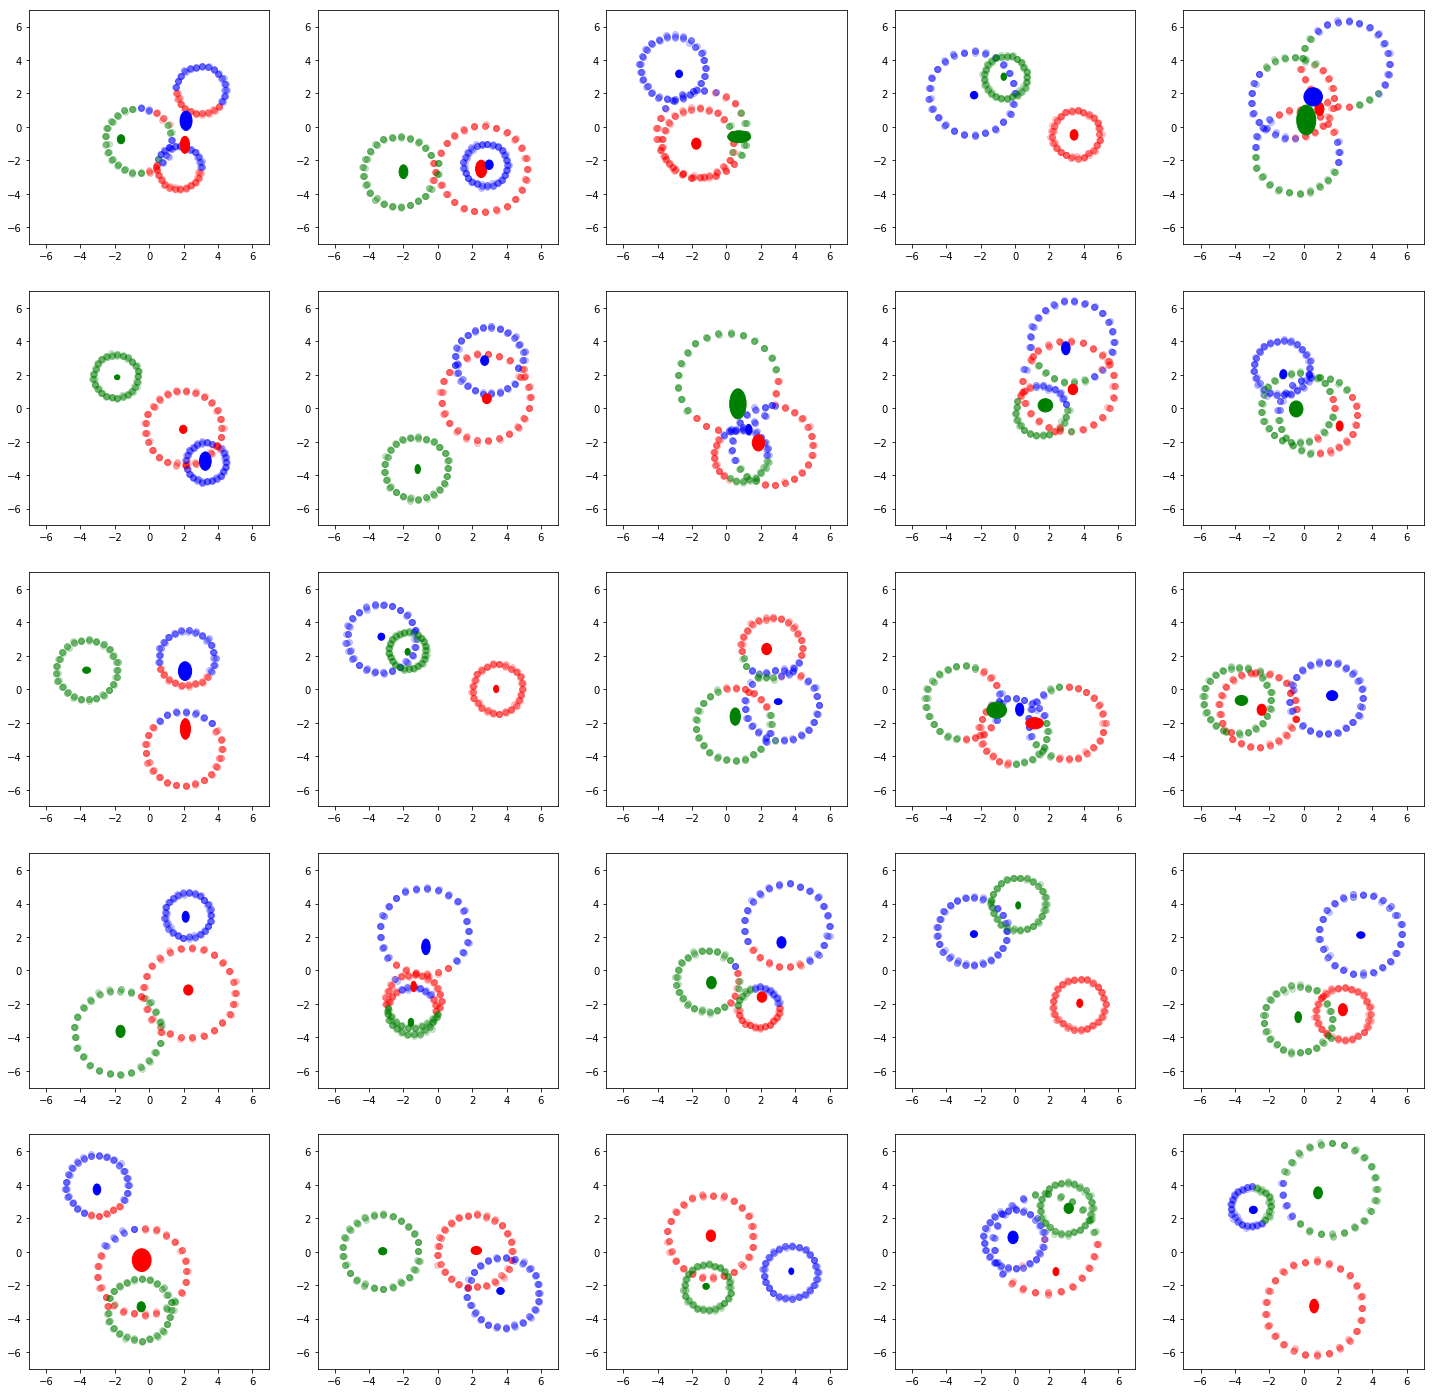

In [13]:
%time plot_samples(obs, q_mu, q_z, K, PATH)

In [ ]:
incremental_gap = symkls_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')